<h1>Logistic Regression</h1>


Linear Regression is for estimating continuous values, such as predicting house prices. However, Linear Regression falls short when the goal shifts to predicting the most likely class for a given data point. In such cases, <u>Logistic</u> Regression emerges as the preferred choice. Unlike Linear Regression, Logistic Regression assesses the probability of a data point belonging to a specific class, thus proving invaluable in classification tasks.

Logistic Regression is a variation of Linear Regression, useful when the dependent variable <i>y</i> is categorical. Despite the name logistic <i>regression</i>, it is a <b>probabilistic classification</b> model. Logistic regression fits a special s-shaped curve by taking the linear regression and transforming the numeric estimate into a probability with the following function:

$$
ProbabilityOfaClass = \theta(y) = \frac{e^y}{1 + e^y}
$$

which produces values between 0 (as y approaches minus infinity $-\infty$) and 1 (as y approaches plus infinity $+\infty$). This now becomes a special kind of non-linear regression.

In the equation, <i>y</i> is the regression result (the sum of the variables weighted by the coefficients), $e$ is the exponential function, and $\theta(y)$ is the logistic function, also called a logistic curve. It is a common "S" shape (sigmoid curve).

In [1]:
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

<h2>Iris Dataset</h2>

<a href="https://archive.ics.uci.edu/ml/datasets/iris">The Iris Dataset</a> consists of 50 samples from each of the three species of Iris. In total, it has 150 records under five attributes and species.

Attributes Independent Variables:
<ul>
    <li>petal length</li>
    <li>petal width</li>
    <li>sepal length</li>
    <li>sepal width</li>
</ul>
Dependent Variables:
<ul>
    <li>Iris setosa</li>
    <li>Iris virginica</li>
    <li>Iris versicolor</li>
</ul>
<br>

Next, we load the dataset pre-built within the sklearn library. Preprocess the features and values, and then we can start using it. Afterward, we separate the dataset into training and testing parts randomly.

In [2]:
dataset = load_iris() # Load the dataset
x, y = dataset.data, dataset.target # Seperate x (independent variable) and y (dependent variable)

# Preprocess the x values by normalizing them:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

# Preprocess the y values by encoding them to one-hot vector:
encoder = OneHotEncoder()
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()

# Split the dataset to train and test sets:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=2024, shuffle=True)

# transform the arrays into tensors
train_x = tf.constant(train_x, dtype=tf.float32)
test_x = tf.constant(test_x, dtype=tf.float32)
train_y = tf.constant(train_y, dtype=tf.float32)
test_y = tf.constant(test_y, dtype=tf.float32)

<h2>Define Model Components</h2>

We start by defining the loss function. Since we want to solve a classification task, we need to define an appropriate loss function that can aid the model in providing valuable signal based on correct predicting the label class. Therefore, we are going to define and use cross-entropy loss function for binary classification as follows:

<!DOCTYPE html>
<html>
<body>
  <p>\[ \text{Binary Cross-Entropy Loss} = - \sum_{i=1}^{N} y_{i} \cdot \log(p_{i}) + (1 - y_{i}) \cdot \log(1 - p_{i}) \]</p>
  <ul>
    <li>\( N \) is the number of samples.</li>
    <li>\( y_{i} \) is the actual label (0 or 1) for the \( i \)th sample.</li>
    <li>\( p_{i} \) is the predicted probability that the \( i \)th sample belongs to the positive class.</li>
  </ul>
  <p>This formula calculates the cross-entropy loss over the entire batch for classification tasks.</p>
</body>
</html>

<h3>Loss Function</h3>

In [3]:
def loss_function(pred, actual):
    loss = - tf.reduce_mean(actual * tf.math.log(pred)
                            + (1 - actual) * tf.math.log(1 - pred))
    return loss

<h3>Logistic Regression Model</h3>

Now, let's define the logistic regression model:

Logistic regression is typically thought of as a single equation:

ŷ = sigmoid(w * x + b)

We can have it broken into its three main components: 

-   a weight times features matrix multiplication operation, 
-   a summation of the weighted features and a bias term, 
-   and the application of a sigmoid function.

The function we are going to use is the <i>logistic function</i> $(\frac{1}{1+e^{-Wx}})$, which is fed the input data after applying weights and bias. In TensorFlow, this function is implemented as the <code>nn.sigmoid</code> function. Effectively, this fits the weighted input with bias into a 0-100 % curve, which is the probability function we want.

We can't use <b>least-squares linear regression</b> here, so we should use Adam optimizer to reduce the loss through looping over the entire batch:

In [4]:
def logistic_regression(features, weights, bias):
    linear_transformation = tf.matmul(features, weights, name='linear_transformation') # Calculate the linear transformation
    with_bias = tf.add(linear_transformation, bias, name='add_bias') # Add the bias term
    output = tf.nn.sigmoid(with_bias, name='sigmoid_activation') # Apply the sigmoid activation function
    return output

In [5]:
def run(learning_rate, total_epochs, train_y, interval_print=10):
    accuracy_values = []
    loss_values = []

    optimizer = tf.keras.optimizers.Adam(learning_rate)

    weights = tf.Variable(tf.random.normal((train_x.shape[-1], 1), mean=0.5, stddev=0.5), dtype=tf.float32)
    bias = tf.Variable(tf.random.normal((1, 1), mean=0.5, stddev=0.5), dtype=tf.float32)
    
    for epoch in range(1, total_epochs + 1):
        with tf.GradientTape() as tape:
            pred = logistic_regression(train_x, weights, bias)
            loss = loss_function(pred, train_y)
        gradient = tape.gradient(loss, [weights, bias])
        optimizer.apply_gradients(zip(gradient, [weights, bias]))
    
        loss_values.append(loss.numpy())
        accuracy = compute_accuracy(pred, train_y)
        accuracy_values.append(accuracy.numpy())
        
        if epoch % interval_print == 0:           
            print(f'Epoch: {epoch:04d} || Train Loss: {loss:.3f}, Train Accuracy: {accuracy:.3f}')

    return {
        'weights' : weights,
        'bias'    : bias,
        'accuracy': accuracy_values,
        'loss'    : loss_values
        }

<h3>Accuracy</h3>
We also want some additional operations to keep track of our model's efficiency over time. We can do this like so:

In [6]:
def compute_accuracy(predicted_y, actual_y):
    # print(predicted_y, '\n', actual_y)
    # correct_prediction = tf.equal(tf.argmax(predicted_y, axis=1), tf.argmax(actual_y, axis=1))
    predicted_y = tf.where(predicted_y > 0.5, 1.0, 0.0)
    correct_prediction = tf.equal(predicted_y, actual_y)
    return tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

<h2>One-vs-All</h2>
<h3>Training</h3>
In the context of training a logistic regression model on the Iris dataset, the One-vs-All (OvA) approach, involves training multiple binary classifiers, each designed to distinguish between one class and the rest of the classes.

The Iris dataset consists of three different classes of iris plants. Since logistic regression is inherently a binary classifier, we need to extend it to handle multi-class classification problems like the Iris dataset.

In [7]:
learning_rate = 0.5
total_epochs = 200


# label 1 - first classifier
train_y_1 = train_y.numpy()[:, 0:2] # transform to NumPy and select index 0 and 1 from the one-hot vector of label
train_y_1[:, -1] = 0 # only label 1 can have 1 and zero value, the second index is all negative, thus 0.
train_y_1 = np.max(train_y_1, axis=1).reshape(-1, 1) # create a single value from the one-hot vector which either is 0 or 1
train_y_1 = tf.constant(train_y_1, dtype=tf.float32) # transform it to tensor for processing

classifier_1 = run(learning_rate, total_epochs, train_y_1) # run the first classifier

#~~~~~~~~~~~~~~~~~~~~~~~~~~~
print()
#~~~~~~~~~~~~~~~~~~~~~~~~~~~

# label 2 - Second classifier
train_y_2 = train_y.numpy()[:, 1:3]
train_y_2[:, -1] = 0
train_y_2 = np.max(train_y_2, axis=1).reshape(-1, 1)
train_y_2 = tf.constant(train_y_2, dtype=tf.float32)

classifier_2 = run(learning_rate, total_epochs, train_y_2)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~
print()
#~~~~~~~~~~~~~~~~~~~~~~~~~~~

# label 3 - Third classifier
train_y_3 = train_y.numpy()[:, 1:3]
train_y_3[:, 0] = 0
train_y_3 = np.max(train_y_3, axis=1).reshape(-1, 1)
train_y_3 = tf.constant(train_y_3, dtype=tf.float32)

classifier_3 = run(learning_rate, total_epochs, train_y_3)

Epoch: 0010 || Train Loss: 0.204, Train Accuracy: 0.967
Epoch: 0020 || Train Loss: 0.072, Train Accuracy: 1.000
Epoch: 0030 || Train Loss: 0.025, Train Accuracy: 1.000
Epoch: 0040 || Train Loss: 0.018, Train Accuracy: 1.000
Epoch: 0050 || Train Loss: 0.013, Train Accuracy: 1.000
Epoch: 0060 || Train Loss: 0.011, Train Accuracy: 1.000
Epoch: 0070 || Train Loss: 0.010, Train Accuracy: 1.000
Epoch: 0080 || Train Loss: 0.009, Train Accuracy: 1.000
Epoch: 0090 || Train Loss: 0.008, Train Accuracy: 1.000
Epoch: 0100 || Train Loss: 0.007, Train Accuracy: 1.000
Epoch: 0110 || Train Loss: 0.007, Train Accuracy: 1.000
Epoch: 0120 || Train Loss: 0.006, Train Accuracy: 1.000
Epoch: 0130 || Train Loss: 0.006, Train Accuracy: 1.000
Epoch: 0140 || Train Loss: 0.005, Train Accuracy: 1.000
Epoch: 0150 || Train Loss: 0.005, Train Accuracy: 1.000
Epoch: 0160 || Train Loss: 0.005, Train Accuracy: 1.000
Epoch: 0170 || Train Loss: 0.004, Train Accuracy: 1.000
Epoch: 0180 || Train Loss: 0.004, Train Accuracy

<h3>Testing</h3>
We utilize the weights and biases of each trained classifier to predict the labels of the test data.

In [8]:
# Label 1
weights = classifier_1['weights']
bias = classifier_1['bias']

label_1 = logistic_regression(test_x, weights, bias)
label_1 = tf.where(label_1 > 0.5, 1.0, 0.0)

In [9]:
# Label 2
weights = classifier_2['weights']
bias = classifier_2['bias']

label_2 = logistic_regression(test_x, weights, bias)
label_2 = tf.where(label_2 > 0.5, 1.0, 0.0)

In [10]:
# Label 3
weights = classifier_3['weights']
bias = classifier_3['bias']

label_3 = logistic_regression(test_x, weights, bias)
label_3 = tf.where(label_3 > 0.5, 1.0, 0.0)

After each classifier has predicted its associated labels, we combine all predictions into a single array. This allows us to evaluate the accuracy of our prediction.

In [11]:
zeroes = np.zeros(shape=(len(test_y), test_y.shape[-1]), dtype=np.uint16)

zeroes[:,0] = label_1.numpy().reshape(-1)
zeroes[:,1] = label_2.numpy().reshape(-1)
zeroes[:,2] = label_3.numpy().reshape(-1)

row_equality = np.all(zeroes == test_y.numpy().astype(np.uint16), axis=1)
num_corrects  = np.mean(row_equality)

print(f'Test Accuracy: {num_corrects:.3f}')

Test Accuracy: 0.733


Let's plot the loss values and accuracy during training to see how it has changed during the training:

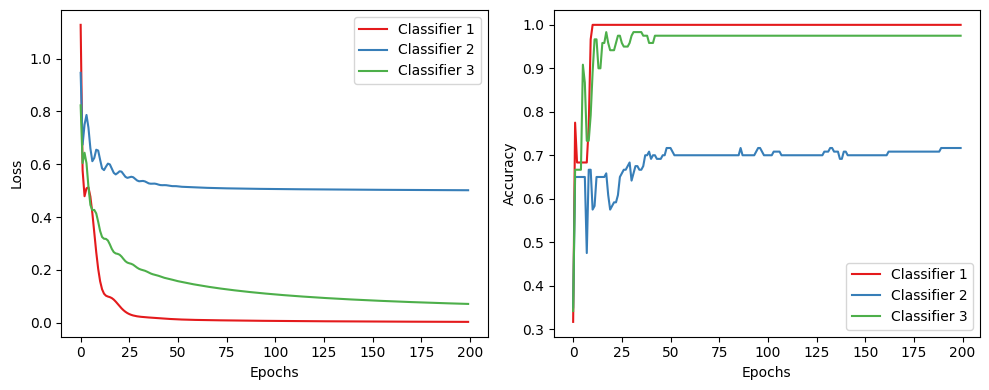

In [14]:
losses = [classifier_1['loss'], classifier_2['loss'], classifier_3['loss']]
accuracy = [classifier_1['accuracy'], classifier_2['accuracy'], classifier_3['accuracy']]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

selected_color_set = 'Set1'
colormap = plt.get_cmap(selected_color_set)

for i, (loss, accuracy) in enumerate(zip(losses, accuracy)):
    ax1.plot(loss, color=colormap(i), label=f'Classifier {i+1}')
    ax2.plot(accuracy, color=colormap(i), label=f'Classifier {i+1}')
    
ax1.set_xlabel("Epochs")
ax1.set_ylabel('Loss')
ax2.set_xlabel("Epochs")
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()

plt.savefig('./plot.png', format='png', dpi=600, bbox_inches='tight', transparent=True)
plt.tight_layout()

plt.show()